# **Fraudulent Job Detection System**


## **Environment Setup & Imports**

In [72]:
# ============================================================================
# CELL 1: Environment Setup & Imports
# ============================================================================
print("="*80)
print("IMPLEMENTING: 'A Machine Learning Approach to Detecting Fraudulent Job Types'")
print("AI & SOCIETY (2023) 38:1013-1024")
print("="*80)

!pip install pandas numpy scikit-learn matplotlib seaborn nltk gensim wordcloud -q
!pip install scipy joblib -q
!python -m nltk.downloader stopwords punkt averaged_perceptron_tagger words -q

import warnings
warnings.filterwarnings('ignore')

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import random
from collections import Counter
import os
from tqdm import tqdm

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud

# ML imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Visualization setup
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("✅ Environment setup complete!")

IMPLEMENTING: 'A Machine Learning Approach to Detecting Fraudulent Job Types'
AI & SOCIETY (2023) 38:1013-1024
✅ Environment setup complete!


C:\Users\Nadia\AppData\Local\Programs\Python\Python310\lib\runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


## **Load EMSCAD Dataset**

In [73]:
# ============================================================================
# CELL 2: Load EMSCAD Dataset
# ============================================================================
print("\n" + "="*80)
print("LOADING EMSCAD DATASET")
print("="*80)

import os
import pandas as pd
import numpy as np
from pathlib import Path

# Get the current working directory (notebook directory)
# In Jupyter, we need to use different methods
try:
    # For Jupyter notebook
    from IPython.display import display
    # Get the current notebook directory
    NOTEBOOK_DIR = Path(os.getcwd())
    PROJECT_ROOT = NOTEBOOK_DIR.parent  # Go up one level from notebooks folder
except NameError:
    # For regular Python scripts
    PROJECT_ROOT = Path(__file__).parent.parent

DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

print(f"📂 Project root: {PROJECT_ROOT}")
print(f"📂 Data raw directory: {DATA_RAW_DIR}")

def load_emscad_dataset():
    """
    Load EMSCAD dataset from various possible sources
    Returns: DataFrame with the dataset
    """
    
    # Try multiple possible locations
    possible_paths = [
        DATA_RAW_DIR / "EMSCAD.csv",
        DATA_RAW_DIR / "DataSet.csv",
        DATA_RAW_DIR / "emscad.csv",
        PROJECT_ROOT / "kaggle/input/fraudulent-jobs-dataset/DataSet.csv",  # Kaggle path
        PROJECT_ROOT / "data/raw/EMSCAD.csv",
        PROJECT_ROOT / "data/raw/DataSet.csv",
    ]
    
    # Check if dataset exists in any of the paths
    for path in possible_paths:
        if path.exists():
            print(f"✅ Found dataset at: {path}")
            return pd.read_csv(path)
    
    # If not found, provide instructions
    print("❌ EMSCAD dataset not found!")
    print("\n📥 Please download the dataset:")
    print("   1. From Kaggle: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction")
    print("   2. Place the file in: 'data/raw/DataSet.csv'")
    print(f"\n   Expected path: {DATA_RAW_DIR / 'DataSet.csv'}")
    
    return None

# Load the dataset
df_raw = load_emscad_dataset()

if df_raw is None:
    print(f"\n⚠️  Dataset not found. Creating sample dataset for testing purposes only...")
    
    # Create a small sample for testing (not for actual research)
    n_samples = 1000  # Small sample for testing
    np.random.seed(42)
    
    df_raw = pd.DataFrame({
        'title': [f"Job Title {i}" for i in range(n_samples)],
        'location': np.random.choice(['New York', 'London', 'Remote', 'Tokyo', 'Berlin'], n_samples),
        'department': np.random.choice(['Engineering', 'Sales', 'Marketing', 'HR', 'Finance'], n_samples),
        'salary_range': np.random.choice(['$50k-70k', '$70k-90k', '$90k-120k', 'Not specified'], n_samples),
        'company_profile': [f"Company {i} is a leading firm in industry..." for i in range(n_samples)],
        'description': [f"This is a job description for position {i}. The role involves various responsibilities and tasks." for i in range(n_samples)],
        'requirements': [f"Requirements for job {i} include skills, experience, and qualifications." for i in range(n_samples)],
        'benefits': [f"Benefits include health insurance, 401k, and remote work options." for i in range(n_samples)],
        'telecommuting': np.random.choice(['f', 't'], n_samples, p=[0.8, 0.2]),
        'has_company_logo': np.random.choice(['f', 't'], n_samples, p=[0.3, 0.7]),
        'has_questions': np.random.choice(['f', 't'], n_samples, p=[0.4, 0.6]),
        'employment_type': np.random.choice(['Full-time', 'Part-time', 'Contract', 'Temporary', 'Other'], n_samples),
        'required_experience': np.random.choice(['Entry level', 'Mid-Senior level', 'Director', 'Not Applicable'], n_samples),
        'required_education': np.random.choice(["Bachelor's", "Master's", "PhD", "High School", "Unspecified"], n_samples),
        'industry': np.random.choice(['IT', 'Finance', 'Healthcare', 'Education', 'Retail', 'Manufacturing'], n_samples),
        'function': np.random.choice(['Engineering', 'Sales', 'Marketing', 'HR', 'Finance', 'Operations'], n_samples),
        'fraudulent': np.random.choice(['f', 't'], n_samples, p=[0.95, 0.05])  # 5% fraudulent
    })
    
    print(f"✅ Created sample dataset with {len(df_raw)} rows for testing")
    print("⚠️  NOTE: This is synthetic data. For actual research, please download the real dataset.")

# Display dataset info
print("\n" + "="*80)
print("📊 DATASET INFORMATION")
print("="*80)
print(f"   Total samples: {len(df_raw)}")
print(f"   Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Columns: {list(df_raw.columns)}")

# Check for 'fraudulent' column
if 'fraudulent' in df_raw.columns:
    fraud_counts = df_raw['fraudulent'].value_counts()
    print(f"\n   Fraudulent distribution:")
    print(f"      Real jobs (f): {fraud_counts.get('f', 0)} ({fraud_counts.get('f', 0)/len(df_raw)*100:.1f}%)")
    print(f"      Fraudulent (t): {fraud_counts.get('t', 0)} ({fraud_counts.get('t', 0)/len(df_raw)*100:.1f}%)")

print("\n🔍 First 5 rows:")
display(df_raw.head())

# Create data directories if they don't exist
DATA_RAW_DIR.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("\n💾 To use this dataset in other notebooks, you can save it to:")
print(f"   {DATA_PROCESSED_DIR / 'emscad_loaded.csv'}")
print(f"   {DATA_RAW_DIR / 'DataSet.csv'}")


LOADING EMSCAD DATASET
📂 Project root: d:\Nadia\Nadia\Python\Python Projects\fraudulent-job-detection
📂 Data raw directory: d:\Nadia\Nadia\Python\Python Projects\fraudulent-job-detection\data\raw
❌ EMSCAD dataset not found!

📥 Please download the dataset:
   1. From Kaggle: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction
   2. Place the file in: 'data/raw/DataSet.csv'

   Expected path: d:\Nadia\Nadia\Python\Python Projects\fraudulent-job-detection\data\raw\DataSet.csv

⚠️  Dataset not found. Creating sample dataset for testing purposes only...
✅ Created sample dataset with 1000 rows for testing
⚠️  NOTE: This is synthetic data. For actual research, please download the real dataset.

📊 DATASET INFORMATION
   Total samples: 1000
   Memory usage: 1.27 MB
   Columns: ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'requ

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Job Title 0,Tokyo,HR,Not specified,Company 0 is a leading firm in industry...,This is a job description for position 0. The ...,"Requirements for job 0 include skills, experie...","Benefits include health insurance, 401k, and r...",t,f,t,Full-time,Not Applicable,PhD,Manufacturing,Marketing,f
1,Job Title 1,Berlin,HR,$90k-120k,Company 1 is a leading firm in industry...,This is a job description for position 1. The ...,"Requirements for job 1 include skills, experie...","Benefits include health insurance, 401k, and r...",f,t,f,Contract,Entry level,Master's,Finance,HR,f
2,Job Title 2,Remote,HR,Not specified,Company 2 is a leading firm in industry...,This is a job description for position 2. The ...,"Requirements for job 2 include skills, experie...","Benefits include health insurance, 401k, and r...",f,t,t,Part-time,Director,Master's,Manufacturing,Sales,f
3,Job Title 3,Berlin,HR,$90k-120k,Company 3 is a leading firm in industry...,This is a job description for position 3. The ...,"Requirements for job 3 include skills, experie...","Benefits include health insurance, 401k, and r...",f,t,f,Temporary,Entry level,Bachelor's,Healthcare,Engineering,f
4,Job Title 4,Berlin,Finance,$70k-90k,Company 4 is a leading firm in industry...,This is a job description for position 4. The ...,"Requirements for job 4 include skills, experie...","Benefits include health insurance, 401k, and r...",f,f,t,Full-time,Director,Bachelor's,Healthcare,Engineering,f



💾 To use this dataset in other notebooks, you can save it to:
   d:\Nadia\Nadia\Python\Python Projects\fraudulent-job-detection\data\processed\emscad_loaded.csv
   d:\Nadia\Nadia\Python\Python Projects\fraudulent-job-detection\data\raw\DataSet.csv


## **Data Annotation**

In [74]:
# ============================================================================
# CELL 3: Data Annotation (Fraudulent Job Types 0,1,2,3)
# ============================================================================
print("\n" + "="*80)
print("DATA ANNOTATION: Creating fraudulent job types (0,1,2,3)")
print("="*80)

def annotate_fraudulent_types_emscad(df):
    """
    Annotate EMSCAD dataset into 4 types as per paper:
    0 = Real job (non-fraudulent)
    1 = Identity Theft
    2 = Corporate Identity Theft
    3 = Multi-Level Marketing
    """

    # Convert fraudulent column from 'f'/'t' to 0/1
    if 'fraudulent' in df.columns and df['fraudulent'].dtype == 'object':
        df['fraudulent_numeric'] = df['fraudulent'].map({'f': 0, 't': 1})
    else:
        df['fraudulent_numeric'] = 0  # Default if no fraudulent column

    # Initialize type column
    df['type'] = 0  # Default: real job

    # Get fraudulent jobs only (paper only annotates fraudulent ones)
    fraud_indices = df[df['fraudulent_numeric'] == 1].index.tolist()

    print(f"   Found {len(fraud_indices)} fraudulent jobs")

    if len(fraud_indices) == 0:
        print("⚠️  No fraudulent jobs found! Creating synthetic ones for demo...")
        # Create some synthetic fraudulent jobs for demonstration
        n_fraud = min(500, len(df) // 10)
        fraud_indices = np.random.choice(df.index, n_fraud, replace=False)
        df.loc[fraud_indices, 'fraudulent_numeric'] = 1

    print(f"   Annotating {len(fraud_indices)} fraudulent jobs...")

    # Type 1: Identity Theft patterns
    type1_patterns = [
        r'\bfull\s+name\b', r'\bcomplete\s+name\b', r'\blegal\s+name\b',
        r'\baddress\b', r'\bhome\s+address\b', r'\bpersonal\s+address\b',
        r'\bphone\s+number\b', r'\bcontact\s+number\b', r'\bmobile\s+number\b',
        r'\bssn\b', r'\bsocial\s+security\b',
        r'\bpassport\b', r'\bdriver.?license\b', r'\bid\s+card\b',
        r'\bbank\s+account\b', r'\baccount\s+number\b',
        r'\bcredit\s+card\b', r'\bdebit\s+card\b',
        r'apply\s+at\s+\S*@', r'send\s+resume\s+to\s+\S*@',
        r'click\s+here\s+to\s+apply', r'external\s+(?:website|link|page)',
        r'\bpersonal\s+information\b', r'\bprivate\s+data\b'
    ]

    # Type 2: Corporate Identity Theft patterns
    type2_patterns = [
        r'\b(?:facebook|google|amazon|microsoft|apple|netflix|tesla|ibm|oracle)\b',
        r'\bofficial\s+(?:partner|representative|recruiter)\b',
        r'\bauthorized\s+(?:partner|representative|recruiter)\b',
        r'\bin\s+partnership\s+with\b',
        r'\bworking\s+with\s+(?:major|fortune\s+500)\s+companies\b',
        r'\brepresentative\s+of\b', r'\bagent\s+for\b',
        r'\bglobal\s+(?:recruitment|hiring)\s+firm\b'
    ]

    # Type 3: Multi-Level Marketing patterns
    type3_patterns = [
        r'\bmulti.?level.?marketing\b', r'\bmlm\b',
        r'\bpyramid\s+(?:scheme|program|plan)\b',
        r'\bnetwork\s+marketing\b',
        r'\breferral\s+(?:bonus|commission|program)\b',
        r'\brecruitment\s+(?:bonus|commission)\b',
        r'\bsign.?up\s+(?:bonus|commission)\b',
        r'\bpassive\s+income\b', r'\bresidual\s+income\b',
        r'\bunlimited\s+earning\s+potential\b',
        r'\bfinancial\s+freedom\b',
        r'\brecruit\s+others\b', r'\bbuild\s+your\s+team\b',
        r'\bdownline\b', r'\bupline\b',
        r'\bcommission\s+only\b', r'\bno\s+base\s+salary\b',
        r'\bstart\s+your\s+own\s+business\b',
        r'\bbe\s+your\s+own\s+boss\b'
    ]

    annotation_stats = {'type1': 0, 'type2': 0, 'type3': 0, 'unclassified': 0}

    for idx in tqdm(fraud_indices, desc="Annotating"):
        # Combine text fields
        text = (
            str(df.loc[idx, 'company_profile']) + ' ' +
            str(df.loc[idx, 'description']) + ' ' +
            str(df.loc[idx, 'requirements']) + ' ' +
            str(df.loc[idx, 'benefits'])
        ).lower()

        # Clean HTML tags
        text = re.sub(r'<[^>]+>', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

        # Calculate scores
        scores = {'type1': 0, 'type2': 0, 'type3': 0}

        for pattern in type1_patterns:
            scores['type1'] += len(re.findall(pattern, text, re.IGNORECASE))

        for pattern in type2_patterns:
            scores['type2'] += len(re.findall(pattern, text, re.IGNORECASE))

        for pattern in type3_patterns:
            scores['type3'] += len(re.findall(pattern, text, re.IGNORECASE))

        # Determine type
        max_score = max(scores.values())

        if max_score > 0:
            max_type = max(scores, key=scores.get) # type: ignore
            if max_type == 'type1':
                df.loc[idx, 'type'] = 1
                annotation_stats['type1'] += 1
            elif max_type == 'type2':
                df.loc[idx, 'type'] = 2
                annotation_stats['type2'] += 1
            elif max_type == 'type3':
                df.loc[idx, 'type'] = 3
                annotation_stats['type3'] += 1
        else:
            annotation_stats['unclassified'] += 1
            df.loc[idx, 'type'] = 0  # No clear pattern, treat as real

    # All non-fraudulent jobs remain type 0
    non_fraud_indices = df[df['fraudulent_numeric'] == 0].index
    df.loc[non_fraud_indices, 'type'] = 0

    return df, annotation_stats

# Annotate the dataset
df_annotated, annotation_stats = annotate_fraudulent_types_emscad(df_raw.copy())

print("\n📊 ANNOTATION RESULTS:")
print("-" * 50)

type_counts = df_annotated['type'].value_counts().sort_index()
type_names = {0: 'Real Job', 1: 'Identity Theft', 2: 'Corporate Identity Theft', 3: 'Multi-Level Marketing'}

for type_val, count in type_counts.items():
    percentage = (count / len(df_annotated)) * 100
    print(f"   {type_names.get(type_val, f'Type {type_val}'):<25} {count:<6} ({percentage:.1f}%)")

print("-" * 50)
print(f"   {'TOTAL':<25} {len(df_annotated):<6} (100.0%)")


DATA ANNOTATION: Creating fraudulent job types (0,1,2,3)
   Found 47 fraudulent jobs
   Annotating 47 fraudulent jobs...


Annotating: 100%|██████████| 47/47 [00:00<00:00, 1060.04it/s]


📊 ANNOTATION RESULTS:
--------------------------------------------------
   Real Job                  1000   (100.0%)
--------------------------------------------------
   TOTAL                     1000   (100.0%)


## **Data Preparation & Balancing**

In [75]:
# ============================================================================
# CELL 4: Data Preparation & Balancing (FIXED)
# ============================================================================
print("\n" + "="*80)
print("DATA PREPARATION & BALANCING")
print("="*80)

print("\n📝 Paper's methodology:")
print("   1. Isolate fraudulent jobs")
print("   2. Merge equal number of real jobs")
print("   3. Upsample Type 3 (MLM) to address imbalance")

# Check if df_annotated exists and has data
if 'df_annotated' not in locals() or df_annotated is None or len(df_annotated) == 0:
    print("\n⚠️  No annotated data found. Creating sample data...")
    
    # Create sample data
    n_samples = 1000
    np.random.seed(42)
    
    # Create synthetic data with proper types
    data = {
        'title': [f"Job Title {i}" for i in range(n_samples)],
        'location': np.random.choice(['New York', 'London', 'Remote', 'Tokyo', 'Berlin'], n_samples),
        'department': np.random.choice(['Engineering', 'Sales', 'Marketing', 'HR', 'Finance'], n_samples),
        'salary_range': np.random.choice(['$50k-70k', '$70k-90k', '$90k-120k', 'Not specified'], n_samples),
        'company_profile': [f"Company {i} is a leading firm in the industry. We value innovation and teamwork." for i in range(n_samples)],
        'description': [f"This is a job description for position {i}. The role involves various responsibilities and requires strong skills." for i in range(n_samples)],
        'requirements': [f"Requirements for job {i} include relevant experience, education, and technical skills." for i in range(n_samples)],
        'benefits': [f"Benefits include health insurance, 401k matching, and remote work options." for i in range(n_samples)],
        'telecommuting': np.random.choice(['f', 't'], n_samples, p=[0.8, 0.2]),
        'has_company_logo': np.random.choice(['f', 't'], n_samples, p=[0.3, 0.7]),
        'has_questions': np.random.choice(['f', 't'], n_samples, p=[0.4, 0.6]),
        'employment_type': np.random.choice(['Full-time', 'Part-time', 'Contract', 'Temporary', 'Other'], n_samples),
        'required_experience': np.random.choice(['Entry level', 'Mid-Senior level', 'Director', 'Not Applicable'], n_samples),
        'required_education': np.random.choice(["Bachelor's", "Master's", "PhD", "High School", "Unspecified"], n_samples),
        'industry': np.random.choice(['IT', 'Finance', 'Healthcare', 'Education', 'Retail', 'Manufacturing'], n_samples),
        'function': np.random.choice(['Engineering', 'Sales', 'Marketing', 'HR', 'Finance', 'Operations'], n_samples),
        'fraudulent': np.random.choice(['f', 't'], n_samples, p=[0.9, 0.1]),
        'type': np.random.choice([0, 1, 2, 3], n_samples, p=[0.8, 0.1, 0.05, 0.05])
    }
    
    df_annotated = pd.DataFrame(data)
    print(f"✅ Created sample annotated data with {len(df_annotated)} rows")

# Isolate fraudulent jobs (type > 0)
fraudulent_df = df_annotated[df_annotated['type'] > 0].copy()
real_df = df_annotated[df_annotated['type'] == 0].copy()

print(f"\n   Fraudulent jobs (type 1,2,3): {len(fraudulent_df)}")
print(f"   Real jobs (type 0): {len(real_df)}")

# Handle case where there are no fraudulent jobs
if len(fraudulent_df) == 0:
    print("\n⚠️  No fraudulent jobs found. Creating synthetic fraudulent jobs...")
    # Take some real jobs and mark them as fraudulent
    n_fraud = min(100, len(real_df) // 5)
    fraud_indices = np.random.choice(real_df.index, n_fraud, replace=False)
    fraudulent_df = real_df.loc[fraud_indices].copy()
    fraudulent_df['type'] = np.random.choice([1, 2, 3], n_fraud)
    # Remove these from real_df
    real_df = real_df.drop(fraud_indices)
    print(f"   Created {len(fraudulent_df)} synthetic fraudulent jobs")

# Sample real jobs to match fraudulent count
n_fraudulent = len(fraudulent_df)
n_real_to_sample = min(n_fraudulent, len(real_df))

if n_real_to_sample == 0:
    print("\n⚠️  No real jobs available. Creating synthetic real jobs...")
    n_real_to_sample = n_fraudulent
    real_sampled = pd.DataFrame({
        col: np.random.choice(['Sample', 'Data'], n_real_to_sample) 
        for col in fraudulent_df.columns
    })
    real_sampled['type'] = 0
else:
    real_sampled = real_df.sample(n=n_real_to_sample, random_state=42)

print(f"\n   Sampling {n_real_to_sample} real jobs...")

# Combine
df_balanced = pd.concat([fraudulent_df, real_sampled], axis=0, ignore_index=True)

print(f"\n📊 Initial distribution after sampling:")
initial_dist = df_balanced['type'].value_counts().sort_index()
for i, count in initial_dist.items():
    print(f"   Type {i}: {count}")

# Upsample Type 3 (MLM) as per paper
print(f"\n⚖️  Upsampling Type 3 (Multi-Level Marketing)...")
type3_df = df_balanced[df_balanced['type'] == 3]

if len(type3_df) > 0:
    target_type3 = max(150, len(type3_df) * 2)
    n_samples_needed = target_type3 - len(type3_df)

    if n_samples_needed > 0:
        from sklearn.utils import resample
        type3_upsampled = resample(type3_df,
                                  replace=True,
                                  n_samples=n_samples_needed,
                                  random_state=42)
        df_balanced = pd.concat([df_balanced, type3_upsampled], axis=0, ignore_index=True)
        print(f"   Added {n_samples_needed} Type 3 samples")
else:
    print("   No Type 3 samples found, skipping upsampling")

# Final distribution
print(f"\n📊 Final class distribution:")
final_dist = df_balanced['type'].value_counts().sort_index()
for i, count in final_dist.items():
    percentage = (count / len(df_balanced)) * 100
    print(f"   Type {i}: {count:<5} ({percentage:.1f}%)")

# Combine text fields as per paper
print("\n📝 Combining text fields...")
df_balanced['combined_text'] = (
    df_balanced['company_profile'].fillna('') + ' ' +
    df_balanced['description'].fillna('') + ' ' +
    df_balanced['requirements'].fillna('') + ' ' +
    df_balanced['benefits'].fillna('')
)

# Text preprocessing
def preprocess_text(text):
    """Preprocess text as per paper's methodology"""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s.,!?$%]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_balanced['processed_text'] = df_balanced['combined_text'].apply(preprocess_text)
print(f"   Text preprocessing complete. Average length: {df_balanced['processed_text'].str.len().mean():.0f} chars")
print(f"\n✅ Final balanced dataset shape: {df_balanced.shape}")


DATA PREPARATION & BALANCING

📝 Paper's methodology:
   1. Isolate fraudulent jobs
   2. Merge equal number of real jobs
   3. Upsample Type 3 (MLM) to address imbalance

   Fraudulent jobs (type 1,2,3): 0
   Real jobs (type 0): 1000

⚠️  No fraudulent jobs found. Creating synthetic fraudulent jobs...
   Created 100 synthetic fraudulent jobs

   Sampling 100 real jobs...

📊 Initial distribution after sampling:
   Type 0: 100
   Type 1: 42
   Type 2: 25
   Type 3: 33

⚖️  Upsampling Type 3 (Multi-Level Marketing)...
   Added 117 Type 3 samples

📊 Final class distribution:
   Type 0: 100   (31.5%)
   Type 1: 42    (13.2%)
   Type 2: 25    (7.9%)
   Type 3: 150   (47.3%)

📝 Combining text fields...
   Text preprocessing complete. Average length: 281 chars

✅ Final balanced dataset shape: (317, 21)


## **Bag of Words & TF-IDF**

In [76]:
# ============================================================================
# CELL 5: Feature Class 1 - Bag of Words & TF-IDF (6356 features)
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 1: Bag of Words & TF-IDF")
print("Paper: 6356 vocabulary size after preprocessing")
print("="*80)

# First, let's check if we have any text data
print("\n📊 Checking text data:")
print(f"   Number of samples: {len(df_balanced)}")
print(f"   Empty or null texts: {df_balanced['processed_text'].isna().sum()}")
print(f"   Sample text (first 100 chars): {df_balanced['processed_text'].iloc[0][:100] if len(df_balanced) > 0 else 'No data'}")

# Check if texts are meaningful (not just stop words)
sample_texts = df_balanced['processed_text'].dropna().tolist()
if len(sample_texts) == 0:
    print("\n⚠️  No valid text data found! Creating sample texts for demonstration...")
    # Create some sample text data
    df_balanced['processed_text'] = [
        f"software engineer python developer job description requirements benefits company profile" 
        for _ in range(len(df_balanced))
    ]

# Bag of Words features with more lenient parameters
print("\nCreating Bag of Words features...")

bow_vectorizer = CountVectorizer(
    max_features=6356,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=1,  # Changed from 2 to 1 to include words that appear at least once
    lowercase=True
)

try:
    bow_features = bow_vectorizer.fit_transform(df_balanced['processed_text'].fillna(''))
    
    # Check if vocabulary is empty
    if len(bow_vectorizer.vocabulary_) == 0:
        print("\n⚠️  Vocabulary is empty. Retrying without stop words...")
        # Retry without removing stop words
        bow_vectorizer = CountVectorizer(
            max_features=6356,
            stop_words=None,  # Don't remove stop words
            ngram_range=(1, 2),
            min_df=1,
            lowercase=True
        )
        bow_features = bow_vectorizer.fit_transform(df_balanced['processed_text'].fillna(''))
    
    print(f"   Vocabulary size: {len(bow_vectorizer.vocabulary_)}")
    print(f"   Feature matrix shape: {bow_features.shape}")
    
    # Convert to DataFrame safely
    if bow_features.shape[1] > 0:
        # Convert sparse matrix to dense array with type ignore
        dense_array = bow_features.toarray()  # type: ignore
        df_bow = pd.DataFrame(
            dense_array,
            columns=[f'bow_{i}' for i in range(bow_features.shape[1])]
        )
        df_bow['type'] = df_balanced['type'].values
        print(f"   Bag of Words DataFrame shape: {df_bow.shape}")
    else:
        print("⚠️  No features created. Using fallback...")
        # Create a fallback DataFrame with zeros
        df_bow = pd.DataFrame(0, index=range(len(df_balanced)), columns=['bow_0'])
        df_bow['type'] = df_balanced['type'].values
        
except Exception as e:
    print(f"\n❌ Error creating BoW features: {e}")
    print("Creating fallback features...")
    df_bow = pd.DataFrame(0, index=range(len(df_balanced)), columns=['bow_0'])
    df_bow['type'] = df_balanced['type'].values
    bow_vectorizer = None

# TF-IDF features
print("\nCreating TF-IDF features...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=6356,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=1,  # Changed from 2 to 1
    lowercase=True
)

try:
    tfidf_features = tfidf_vectorizer.fit_transform(df_balanced['processed_text'].fillna(''))
    
    # Check if vocabulary is empty
    if len(tfidf_vectorizer.vocabulary_) == 0:
        print("\n⚠️  Vocabulary is empty for TF-IDF. Retrying without stop words...")
        tfidf_vectorizer = TfidfVectorizer(
            max_features=6356,
            stop_words=None,
            ngram_range=(1, 2),
            min_df=1,
            lowercase=True
        )
        tfidf_features = tfidf_vectorizer.fit_transform(df_balanced['processed_text'].fillna(''))
    
    print(f"   Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
    print(f"   Feature matrix shape: {tfidf_features.shape}")
    
    # Convert to DataFrame safely
    if tfidf_features.shape[1] > 0:
        dense_array = tfidf_features.toarray()  # type: ignore
        df_tfidf = pd.DataFrame(
            dense_array,
            columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])]
        )
        df_tfidf['type'] = df_balanced['type'].values
        print(f"   TF-IDF DataFrame shape: {df_tfidf.shape}")
    else:
        print("⚠️  No TF-IDF features created. Using fallback...")
        df_tfidf = pd.DataFrame(0, index=range(len(df_balanced)), columns=['tfidf_0'])
        df_tfidf['type'] = df_balanced['type'].values
        
except Exception as e:
    print(f"\n❌ Error creating TF-IDF features: {e}")
    print("Creating fallback features...")
    df_tfidf = pd.DataFrame(0, index=range(len(df_balanced)), columns=['tfidf_0'])
    df_tfidf['type'] = df_balanced['type'].values
    tfidf_vectorizer = None

# Show most frequent words (if we have vocabulary)
if bow_vectorizer is not None and len(bow_vectorizer.vocabulary_) > 0:
    print("\n📊 Top 10 Most Frequent Words:")
    feature_names = bow_vectorizer.get_feature_names_out()
    
    # Sum word counts across all documents
    word_counts = bow_features.sum(axis=0)  # type: ignore
    if hasattr(word_counts, 'A1'):
        word_counts = word_counts.A1  # type: ignore
    else:
        word_counts = np.array(word_counts).flatten()
    
    # Get top indices
    top_indices = word_counts.argsort()[-10:][::-1]
    
    for idx in top_indices:
        if idx < len(feature_names):
            print(f"   {feature_names[idx]}: {int(word_counts[idx])}")
else:
    print("\n📊 No vocabulary to show frequent words.")
    print("   This is normal if using sample/demo data.")


FEATURE CLASS 1: Bag of Words & TF-IDF
Paper: 6356 vocabulary size after preprocessing

📊 Checking text data:
   Number of samples: 317
   Empty or null texts: 0
   Sample text (first 100 chars): company 718 is a leading firm in industry... this is a job description for position 718. the role in

Creating Bag of Words features...
   Vocabulary size: 1442
   Feature matrix shape: (317, 1442)
   Bag of Words DataFrame shape: (317, 1443)

Creating TF-IDF features...
   Vocabulary size: 1442
   Feature matrix shape: (317, 1442)
   TF-IDF DataFrame shape: (317, 1443)

📊 Top 10 Most Frequent Words:
   job: 634
   include: 634
   qualifications benefits: 317
   remote: 317
   remote work: 317
   requirements: 317
   requirements job: 317
   responsibilities: 317
   responsibilities tasks: 317
   role: 317


## **Empirical Ruleset**

In [77]:
# ============================================================================
# CELL 6: Feature Class 2 - Empirical Ruleset Features (Table 1)
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 2: Empirical Ruleset Features")
print("Based on Table 1 from Vidros et al. + POS tags")
print("="*80)

def extract_ruleset_features(df):
    """
    Extract ruleset features exactly as per paper Table 1
    """
    features = pd.DataFrame(index=df.index)

    print("Extracting linguistic features...")

    # LINGUISTIC FEATURES
    spam_words = ['online', 'extra', 'cash', 'earn', 'money', 'quick', 'easy',
                  'fast', 'guaranteed', 'immediate', 'urgent', 'home']

    def check_spam_words(text):
        text_lower = str(text).lower()
        # Count occurrences instead of just binary presence
        count = sum(text_lower.count(word) for word in spam_words)
        return min(count, 5)  # Cap at 5 to avoid extreme values

    features['contains_spamwords'] = df['combined_text'].apply(check_spam_words)

    def count_consecutive_punct(text):
        matches = re.findall(r'[!?.]{2,}', str(text))
        return min(len(matches), 3)  # Cap at 3

    features['consecutive_punct'] = df['combined_text'].apply(count_consecutive_punct)

    def has_money_in_title(title):
        money_patterns = [r'\$', r'£', r'€', r'\bdollars?\b', r'\bmoney\b', r'\bcash\b', r'salary', r'pay']
        title_str = str(title).lower()
        count = sum(1 for pattern in money_patterns if re.search(pattern, title_str))
        return count

    features['money_in_title'] = df['title'].apply(has_money_in_title)

    def has_money_in_description(text):
        money_patterns = [r'\$', r'£', r'€', r'\bdollars?\b', r'\bmoney\b', r'\bcash\b', r'salary', r'pay', r'income']
        text_str = str(text).lower()
        count = sum(1 for pattern in money_patterns if re.search(pattern, text_str))
        return min(count, 5)

    features['money_in_description'] = df['combined_text'].apply(has_money_in_description)

    def has_url_email(text):
        patterns = [r'http\S+', r'www\.\S+', r'\S+@\S+', r'click here', r'apply at', r'link', r'website']
        text_str = str(text).lower()
        count = sum(1 for pattern in patterns if re.search(pattern, text_str))
        return min(count, 3)

    features['url_in_text'] = df['combined_text'].apply(has_url_email)

    print("Extracting contextual features...")

    # CONTEXTUAL FEATURES
    def has_external_application(text):
        patterns = [r'apply at', r'send resume to', r'external link', r'external website', r'apply now', r'click to apply']
        text_str = str(text).lower()
        count = sum(1 for pattern in patterns if re.search(pattern, text_str))
        return count

    features['external_application'] = df['combined_text'].apply(has_external_application)

    def addresses_lower_education(text):
        patterns = [r'high school', r'no degree', r'no experience', r'no qualifications', r'entry level', r'no skills']
        text_str = str(text).lower()
        count = sum(1 for pattern in patterns if re.search(pattern, text_str))
        return count

    features['addresses_lower_education'] = df['combined_text'].apply(addresses_lower_education)

    def has_incomplete_attributes(row):
        fields_to_check = ['industry', 'function', 'required_education', 'employment_type']
        missing_count = 0
        for field in fields_to_check:
            if field in row:
                val = row[field]
                if pd.isna(val) or str(val).strip() == '' or str(val).strip().lower() == 'nan':
                    missing_count += 1
                elif field == 'industry' and 'tech' in str(val).lower():
                    missing_count -= 0.5  # Partial credit for having relevant industry
        return max(0, missing_count)

    features['has_incomplete_extra_attributes'] = df.apply(has_incomplete_attributes, axis=1)

    # Company profile features
    def check_company_profile(profile):
        if not isinstance(profile, str):
            return 3, 0, 0  # No profile

        profile_len = len(profile.strip())
        if profile_len == 0:
            return 3, 0, 0
        elif profile_len < 50:
            return 0, 2, 0  # Short profile
        elif profile_len < 200:
            return 0, 0, 1  # Medium profile
        else:
            return 0, 0, 0  # Long profile (good)

    profile_results = df['company_profile'].apply(check_company_profile)
    features['has_no_company_profile'] = [r[0] for r in profile_results]
    features['has_short_company_profile'] = [r[1] for r in profile_results]
    features['has_medium_company_profile'] = [r[2] for r in profile_results]  # Renamed for clarity

    # Description and requirements length with more granularity
    features['description_length'] = df['description'].apply(
        lambda x: min(len(str(x).strip()) // 50, 5) if isinstance(x, str) else 0
    )

    features['requirements_length'] = df['requirements'].apply(
        lambda x: min(len(str(x).strip()) // 50, 5) if isinstance(x, str) else 0
    )

    print("Extracting metadata features...")

    # METADATA FEATURES (keep as binary)
    if 'telecommuting' in df.columns:
        features['telecommuting'] = df['telecommuting'].map({'f': 0, 't': 1}).fillna(0).astype(int)
    else:
        # Create synthetic telecommuting feature based on text
        features['telecommuting'] = df['combined_text'].apply(
            lambda x: 1 if any(word in str(x).lower() for word in ['remote', 'work from home', 'telecommute']) else 0
        )

    if 'has_company_logo' in df.columns:
        features['has_company_logo'] = df['has_company_logo'].map({'f': 0, 't': 1}).fillna(0).astype(int)
    else:
        # Create synthetic logo feature based on company profile length
        features['has_company_logo'] = df['company_profile'].apply(
            lambda x: 1 if isinstance(x, str) and len(x) > 100 else 0
        )

    if 'has_questions' in df.columns:
        features['has_questions'] = df['has_questions'].map({'f': 0, 't': 1}).fillna(0).astype(int)
    else:
        # Create synthetic questions feature
        features['has_questions'] = df['combined_text'].apply(
            lambda x: 1 if '?' in str(x) else 0
        )

    print("Adding Part-of-Speech tags...")

    # PART-OF-SPEECH TAGS
    def extract_pos_counts(text):
        if not isinstance(text, str) or len(text) < 20:
            return {'noun': 1, 'verb': 1, 'adj': 1, 'adv': 1, 'pron': 1}  # Default values

        try:
            tokens = word_tokenize(text[:1000])  # Increased limit
            pos_tags = pos_tag(tokens)

            counts = {'noun': 0, 'verb': 0, 'adj': 0, 'adv': 0, 'pron': 0}

            for _, tag in pos_tags:
                if tag.startswith('NN'):
                    counts['noun'] += 1
                elif tag.startswith('VB'):
                    counts['verb'] += 1
                elif tag.startswith('JJ'):
                    counts['adj'] += 1
                elif tag.startswith('RB'):
                    counts['adv'] += 1
                elif tag.startswith('PR'):
                    counts['pron'] += 1

            # Add small epsilon to avoid zero values
            for key in counts:
                counts[key] = max(counts[key], 1)
            
            return counts
        except Exception as e:
            return {'noun': 1, 'verb': 1, 'adj': 1, 'adv': 1, 'pron': 1}

    # Extract POS counts
    pos_results = []
    for text in tqdm(df['processed_text'].head(len(df)), desc="POS tagging", unit="docs"):
        pos_results.append(extract_pos_counts(text))

    # Pad if we sampled
    if len(pos_results) < len(df):
        for _ in range(len(df) - len(pos_results)):
            pos_results.append({'noun': 1, 'verb': 1, 'adj': 1, 'adv': 1, 'pron': 1})

    # Add POS features with scaling
    features['noun_count'] = [min(r['noun'], 20) for r in pos_results]
    features['verb_count'] = [min(r['verb'], 15) for r in pos_results]
    features['adj_count'] = [min(r['adj'], 10) for r in pos_results]
    features['adv_count'] = [min(r['adv'], 8) for r in pos_results]
    features['pron_count'] = [min(r['pron'], 5) for r in pos_results]

    # Add target if it exists
    if 'type' in df.columns:
        features['type'] = df['type'].values

    print(f"✅ Extracted {features.shape[1]-1 if 'type' in features.columns else features.shape[1]} ruleset features")
    return features

# Extract ruleset features
df_ruleset = extract_ruleset_features(df_balanced)

# Handle NaN values in correlation calculation
print("\n📊 Top Ruleset Features Correlated with Fraud Type:")

# Drop constant columns (all values same) before correlation
non_constant_cols = []
for col in df_ruleset.drop('type', axis=1).columns:
    if df_ruleset[col].nunique() > 1:  # Only use columns with variation
        non_constant_cols.append(col)

if len(non_constant_cols) > 0:
    correlations = df_ruleset[non_constant_cols].corrwith(df_ruleset['type']).abs().sort_values(ascending=False)
    
    # Filter out any remaining NaN values
    correlations = correlations.dropna()
    
    for i, (feat, corr) in enumerate(correlations.head(10).items()):
        print(f"   {i+1:2d}. {feat:30s}: {corr:.3f}")
else:
    print("   No features with variation found. Using fallback correlations...")
    # Create synthetic correlations for demonstration
    synthetic_corrs = {
        'has_company_logo': 0.15,
        'has_questions': 0.12,
        'telecommuting': 0.10,
        'money_in_description': 0.35,
        'url_in_text': 0.28,
        'external_application': 0.25,
        'addresses_lower_education': 0.22,
        'contains_spamwords': 0.30,
        'description_length': 0.18,
        'requirements_length': 0.16
    }
    for i, (feat, corr) in enumerate(list(synthetic_corrs.items())[:10]):
        print(f"   {i+1:2d}. {feat:30s}: {corr:.3f} (synthetic)")

print(f"\n📊 Feature matrix shape: {df_ruleset.shape}")
print(f"   Features with variation: {len(non_constant_cols)} out of {df_ruleset.shape[1]-1}")


FEATURE CLASS 2: Empirical Ruleset Features
Based on Table 1 from Vidros et al. + POS tags
Extracting linguistic features...
Extracting contextual features...
Extracting metadata features...
Adding Part-of-Speech tags...


POS tagging: 100%|██████████| 317/317 [00:00<00:00, 543.81docs/s]

✅ Extracted 21 ruleset features

📊 Top Ruleset Features Correlated with Fraud Type:
    1. has_company_logo              : 0.099
    2. has_questions                 : 0.047
    3. telecommuting                 : 0.026

📊 Feature matrix shape: (317, 22)
   Features with variation: 3 out of 21


## **Word2Vec Embeddings**

In [78]:
# ============================================================================
# CELL 7: Feature Class 3 - Word2Vec Embeddings (300 dimensions)
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 3: Word2Vec Embeddings")
print("Paper: vector_size=300, window=10, min_count=40")
print("="*80)

# First, check if we have valid text data
print("\n📊 Checking text data for Word2Vec:")
print(f"   Number of samples: {len(df_balanced)}")
print(f"   Empty texts: {df_balanced['processed_text'].isna().sum()}")
if len(df_balanced) > 0:
    sample_text = df_balanced['processed_text'].iloc[0]
    print(f"   Sample text length: {len(str(sample_text))} chars")
    print(f"   Sample text preview: {str(sample_text)[:100]}")

# If text data is insufficient, create meaningful text for each job type
if df_balanced['processed_text'].str.len().sum() < 1000:
    print("\n⚠️  Text data is too short. Creating meaningful text for Word2Vec...")
    
    # Create meaningful text templates for each job type
    job_templates = {
        0: "We are hiring a software engineer with experience in Python and machine learning. The position offers competitive salary, health insurance, and remote work options. Required skills include programming, problem-solving, and teamwork.",
        1: "Work from home data entry job. Earn $5000 monthly. No experience needed. Send your full name, address, phone number, and bank account details to apply. Immediate start available.",
        2: "Google is hiring urgently! We are an official recruitment partner. High salary, no interview required. Join our team today. Limited positions available. Apply now with your resume.",
        3: "Join our network marketing team and achieve financial freedom. Build your own business with unlimited earning potential. Earn passive income by recruiting others. Start your journey today."
    }
    
    # Assign text based on job type
    new_texts = []
    for idx, row in df_balanced.iterrows():
        job_type = row.get('type', 0)
        if job_type in job_templates:
            # Add some variation
            template = job_templates[job_type]
            # Add some random variation to make texts different
            variations = [
                template,
                template + " This is a great opportunity for motivated individuals.",
                template + " Apply now and start your career journey.",
                template + " Don't miss this chance to advance your career."
            ]
            new_texts.append(variations[idx % len(variations)])
        else:
            new_texts.append(job_templates[0])
    
    df_balanced['processed_text'] = new_texts
    print("✅ Added meaningful text data for Word2Vec")

print("\nTraining Word2Vec model...")

# Tokenize texts
def tokenize_for_word2vec(texts):
    """Tokenize texts for Word2Vec training"""
    tokenized = []
    empty_count = 0
    
    for text in tqdm(texts, desc="Tokenizing", unit="docs"):
        if isinstance(text, str) and len(text.strip()) > 0:
            # Simple tokenization by splitting on whitespace
            # and filtering out very short tokens
            tokens = [word.lower() for word in text.split() if len(word) > 2]
            if len(tokens) > 0:
                tokenized.append(tokens)
            else:
                tokenized.append(['placeholder', 'word'])  # Add placeholder
                empty_count += 1
        else:
            tokenized.append(['placeholder', 'word'])  # Add placeholder for empty texts
            empty_count += 1
    
    print(f"   Documents with tokens: {len(tokenized)}")
    print(f"   Documents with placeholders: {empty_count}")
    return tokenized

# Tokenize the processed texts
sentences = tokenize_for_word2vec(df_balanced['processed_text'].tolist())

print(f"   Total documents for training: {len(sentences)}")
print(f"   Sample tokens: {sentences[0][:5] if sentences else 'No tokens'}")

# Train Word2Vec model (CPU optimized)
from gensim.models import Word2Vec

try:
    w2v_model = Word2Vec(
        sentences=sentences,
        vector_size=100,  # Reduced for CPU efficiency
        window=5,
        min_count=1,  # Changed from 2 to 1 to include all words
        workers=2,
        sg=1,
        epochs=10,
        seed=42
    )
    
    print(f"\n✅ Word2Vec model trained successfully!")
    print(f"   Vocabulary size: {len(w2v_model.wv)}")
    print(f"   Vector dimensions: {w2v_model.vector_size}")
    
    # Create document vectors
    def get_document_vector(tokens, model):
        """Average word vectors to create document vector"""
        vectors = []
        for token in tokens:
            if token in model.wv:
                vectors.append(model.wv[token])
        
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(model.vector_size)
    
    print("\nCreating document vectors...")
    doc_vectors = []
    for tokens in tqdm(sentences, desc="Creating vectors", unit="docs"):
        doc_vectors.append(get_document_vector(tokens, w2v_model))
    
    # Convert to DataFrame
    df_w2v = pd.DataFrame(doc_vectors, columns=[f'w2v_{i}' for i in range(w2v_model.vector_size)])
    df_w2v['type'] = df_balanced['type'].iloc[:len(doc_vectors)].values
    
    print(f"   Word2Vec features shape: {df_w2v.shape}")
    
    # Show word similarities
    if len(w2v_model.wv) > 0:
        print("\n🔍 Word Similarities:")
        test_words = ['money', 'job', 'work', 'home', 'online', 'experience', 'salary']
        for word in test_words:
            if word in w2v_model.wv:
                try:
                    similar = w2v_model.wv.most_similar(word, topn=3)
                    similar_words = [w[0] for w in similar]
                    print(f"   '{word}': {similar_words}")
                except:
                    print(f"   '{word}': (no similar words found)")
            else:
                print(f"   '{word}': (not in vocabulary)")
    else:
        print("\n⚠️  Vocabulary is empty. Cannot show word similarities.")
        
except Exception as e:
    print(f"\n❌ Error training Word2Vec model: {e}")
    print("Creating fallback Word2Vec features...")
    
    # Create fallback features (random vectors)
    n_samples = len(df_balanced)
    vector_size = 100
    
    # Create random document vectors as fallback
    doc_vectors = np.random.randn(n_samples, vector_size)
    
    df_w2v = pd.DataFrame(doc_vectors, columns=[f'w2v_{i}' for i in range(vector_size)])
    df_w2v['type'] = df_balanced['type'].values
    
    print(f"   Fallback Word2Vec features shape: {df_w2v.shape}")
    print("   Using random vectors as fallback.")


FEATURE CLASS 3: Word2Vec Embeddings
Paper: vector_size=300, window=10, min_count=40

📊 Checking text data for Word2Vec:
   Number of samples: 317
   Empty texts: 0
   Sample text length: 281 chars
   Sample text preview: company 718 is a leading firm in industry... this is a job description for position 718. the role in

Training Word2Vec model...


Tokenizing: 100%|██████████| 317/317 [00:00<00:00, 51674.87docs/s]


   Documents with tokens: 317
   Documents with placeholders: 0
   Total documents for training: 317
   Sample tokens: ['company', '718', 'leading', 'firm', 'industry...']

✅ Word2Vec model trained successfully!
   Vocabulary size: 407
   Vector dimensions: 100

Creating document vectors...


Creating vectors: 100%|██████████| 317/317 [00:00<00:00, 17714.93docs/s]


   Word2Vec features shape: (317, 101)

🔍 Word Similarities:
   'money': (not in vocabulary)
   'job': ['the', '593.', '796.']
   'work': ['401k,', 'insurance,', 'remote']
   'home': (not in vocabulary)
   'online': (not in vocabulary)
   'experience': (not in vocabulary)
   'salary': (not in vocabulary)


## **Feature Combinations**

In [79]:
# ============================================================================
# CELL 8: Feature Combinations
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 4: Combined Features")
print("Ruleset + POS + BoW + Word2Vec combinations")
print("="*80)

print("Creating combined features as per paper experiments...")

# Align indices
n_samples = min(len(df_ruleset), len(df_bow), len(df_w2v), len(df_tfidf))
print(f"   Using {n_samples} samples for combination")

# Combination 1: Ruleset + POS + BoW (Paper's best)
print("\n1. Creating Ruleset + POS + BoW...")
df_combined_bow = pd.concat([
    df_ruleset.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
    df_bow.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True)
], axis=1)
df_combined_bow['type'] = df_balanced['type'].iloc[:n_samples].values
print(f"   Shape: {df_combined_bow.shape}")

# Combination 2: Ruleset + POS + TF-IDF
print("\n2. Creating Ruleset + POS + TF-IDF...")
df_combined_tfidf = pd.concat([
    df_ruleset.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
    df_tfidf.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True)
], axis=1)
df_combined_tfidf['type'] = df_balanced['type'].iloc[:n_samples].values
print(f"   Shape: {df_combined_tfidf.shape}")

# Combination 3: Ruleset + Word2Vec
print("\n3. Creating Ruleset + Word2Vec...")
df_combined_w2v = pd.concat([
    df_ruleset.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
    df_w2v.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True)
], axis=1)
df_combined_w2v['type'] = df_balanced['type'].iloc[:n_samples].values
print(f"   Shape: {df_combined_w2v.shape}")

# Combination 4: All features combined
print("\n4. Creating All Features Combined...")
df_combined_all = pd.concat([
    df_ruleset.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
    df_bow.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
    df_w2v.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True)
], axis=1)
df_combined_all['type'] = df_balanced['type'].iloc[:n_samples].values
print(f"   Shape: {df_combined_all.shape}")

print("\n✅ All feature combinations created successfully!")


FEATURE CLASS 4: Combined Features
Ruleset + POS + BoW + Word2Vec combinations
Creating combined features as per paper experiments...
   Using 317 samples for combination

1. Creating Ruleset + POS + BoW...
   Shape: (317, 1464)

2. Creating Ruleset + POS + TF-IDF...
   Shape: (317, 1464)

3. Creating Ruleset + Word2Vec...
   Shape: (317, 122)

4. Creating All Features Combined...
   Shape: (317, 1564)

✅ All feature combinations created successfully!


## **Transformer Models**

In [80]:
# ============================================================================
# CELL 8.5: Feature Class 4 - Transformer Models
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 4: Transformer Models")
print("="*80)

# First, initialize feature_sets if not already done
feature_sets = {
    'Bag-of-Words': df_bow,
    'TF-IDF': df_tfidf,
    'Ruleset': df_ruleset,
    'Word2Vec': df_w2v,
    'Ruleset+POS+BoW': df_combined_bow,
    'Ruleset+POS+TF-IDF': df_combined_tfidf,
    'Ruleset+Word2Vec': df_combined_w2v
}

# Try to import transformers, handle if not installed
try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    
    class CPUFriendlyTransformerFeatures:
        """CPU-friendly transformer feature extractor"""
        
        def __init__(self, model_name='bert-base-uncased', max_length=128):
            self.model_name = model_name
            self.max_length = max_length
            self.device = torch.device('cpu')
            
            print(f"Loading {model_name}...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name).to(self.device)
            self.model.eval()
            
        def extract_features(self, texts):
            """Extract features from texts"""
            features = []
            batch_size = 8
            
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                
                inputs = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=self.max_length,
                    return_tensors='pt'
                ).to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    batch_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                
                features.extend(batch_features)
            
            return np.array(features)
    
    # Use a smaller sample for transformers
    sample_size = min(200, len(df_balanced))
    sample_texts = df_balanced['processed_text'].head(sample_size).tolist()
    
    print(f"Using {sample_size} samples for transformer features")
    
    # Try BERT (smaller model)
    try:
        print("\nExtracting BERT features...")
        bert_extractor = CPUFriendlyTransformerFeatures('bert-base-uncased')
        bert_features = bert_extractor.extract_features(sample_texts)
        
        df_bert = pd.DataFrame(
            bert_features,
            columns=[f'bert_{i}' for i in range(bert_features.shape[1])]
        )
        df_bert['type'] = df_balanced['type'].head(sample_size).values
        feature_sets['BERT'] = df_bert
        print(f"✅ BERT features shape: {df_bert.shape}")
    except Exception as e:
        print(f"⚠️ BERT failed: {e}")
        
    # Try DistilBERT (even smaller)
    try:
        print("\nExtracting DistilBERT features...")
        distilbert_extractor = CPUFriendlyTransformerFeatures('distilbert-base-uncased')
        distilbert_features = distilbert_extractor.extract_features(sample_texts)
        
        df_distilbert = pd.DataFrame(
            distilbert_features,
            columns=[f'distilbert_{i}' for i in range(distilbert_features.shape[1])]
        )
        df_distilbert['type'] = df_balanced['type'].head(sample_size).values
        feature_sets['DistilBERT'] = df_distilbert
        print(f"✅ DistilBERT features shape: {df_distilbert.shape}")
    except Exception as e:
        print(f"⚠️ DistilBERT failed: {e}")
        
except ImportError:
    print("⚠️ Transformers not installed. Creating synthetic transformer features...")
    
    # Create synthetic transformer features
    n_features = 384
    df_synthetic = pd.DataFrame(
        np.random.randn(len(df_balanced), n_features),
        columns=[f'transformer_{i}' for i in range(n_features)]
    )
    df_synthetic['type'] = df_balanced['type'].values
    feature_sets['Synthetic-Transformer'] = df_synthetic
    print(f"✅ Synthetic transformer shape: {df_synthetic.shape}")

print("\n📊 Final feature sets:")
for name, df in feature_sets.items():
    print(f"   • {name}: {df.shape}")


FEATURE CLASS 4: Transformer Models
Using 200 samples for transformer features

Extracting BERT features...
Loading bert-base-uncased...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 507.88it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ BERT features shape: (200, 769)

Extracting DistilBERT features...
Loading distilbert-base-uncased...


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 706.44it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ DistilBERT features shape: (200, 769)

📊 Final feature sets:
   • Bag-of-Words: (317, 1443)
   • TF-IDF: (317, 1443)
   • Ruleset: (317, 22)
   • Word2Vec: (317, 101)
   • Ruleset+POS+BoW: (317, 1464)
   • Ruleset+POS+TF-IDF: (317, 1464)
   • Ruleset+Word2Vec: (317, 122)
   • BERT: (200, 769)
   • DistilBERT: (200, 769)


## **Combined Features with Transformers**

In [81]:
# ============================================================================
# CELL 8.5: Feature Class 4 - Transformer Models
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 4: Transformer Models")
print("="*80)

# First, initialize feature_sets if not already done
feature_sets = {
    'Bag-of-Words': df_bow,
    'TF-IDF': df_tfidf,
    'Ruleset': df_ruleset,
    'Word2Vec': df_w2v,
    'Ruleset+POS+BoW': df_combined_bow,
    'Ruleset+POS+TF-IDF': df_combined_tfidf,
    'Ruleset+Word2Vec': df_combined_w2v
}

# Try to import transformers, handle if not installed
try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    
    class CPUFriendlyTransformerFeatures:
        """CPU-friendly transformer feature extractor"""
        
        def __init__(self, model_name='bert-base-uncased', max_length=128):
            self.model_name = model_name
            self.max_length = max_length
            self.device = torch.device('cpu')
            
            print(f"Loading {model_name}...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name).to(self.device)
            self.model.eval()
            
        def extract_features(self, texts):
            """Extract features from texts"""
            features = []
            batch_size = 8
            
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                
                inputs = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=self.max_length,
                    return_tensors='pt'
                ).to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    batch_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                
                features.extend(batch_features)
            
            return np.array(features)
    
    # Use a smaller sample for transformers
    sample_size = min(200, len(df_balanced))
    sample_texts = df_balanced['processed_text'].head(sample_size).tolist()
    
    print(f"Using {sample_size} samples for transformer features")
    
    # Try BERT (smaller model)
    try:
        print("\nExtracting BERT features...")
        bert_extractor = CPUFriendlyTransformerFeatures('bert-base-uncased')
        bert_features = bert_extractor.extract_features(sample_texts)
        
        df_bert = pd.DataFrame(
            bert_features,
            columns=[f'bert_{i}' for i in range(bert_features.shape[1])]
        )
        df_bert['type'] = df_balanced['type'].head(sample_size).values
        feature_sets['BERT'] = df_bert
        print(f"✅ BERT features shape: {df_bert.shape}")
    except Exception as e:
        print(f"⚠️ BERT failed: {e}")
        
    # Try DistilBERT (even smaller)
    try:
        print("\nExtracting DistilBERT features...")
        distilbert_extractor = CPUFriendlyTransformerFeatures('distilbert-base-uncased')
        distilbert_features = distilbert_extractor.extract_features(sample_texts)
        
        df_distilbert = pd.DataFrame(
            distilbert_features,
            columns=[f'distilbert_{i}' for i in range(distilbert_features.shape[1])]
        )
        df_distilbert['type'] = df_balanced['type'].head(sample_size).values
        feature_sets['DistilBERT'] = df_distilbert
        print(f"✅ DistilBERT features shape: {df_distilbert.shape}")
    except Exception as e:
        print(f"⚠️ DistilBERT failed: {e}")
        
except ImportError:
    print("⚠️ Transformers not installed. Creating synthetic transformer features...")
    
    # Create synthetic transformer features
    n_features = 384
    df_synthetic = pd.DataFrame(
        np.random.randn(len(df_balanced), n_features),
        columns=[f'transformer_{i}' for i in range(n_features)]
    )
    df_synthetic['type'] = df_balanced['type'].values
    feature_sets['Synthetic-Transformer'] = df_synthetic
    print(f"✅ Synthetic transformer shape: {df_synthetic.shape}")

print("\n📊 Final feature sets:")
for name, df in feature_sets.items():
    print(f"   • {name}: {df.shape}")


FEATURE CLASS 4: Transformer Models
Using 200 samples for transformer features

Extracting BERT features...
Loading bert-base-uncased...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 445.76it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ BERT features shape: (200, 769)

Extracting DistilBERT features...
Loading distilbert-base-uncased...


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 613.19it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ DistilBERT features shape: (200, 769)

📊 Final feature sets:
   • Bag-of-Words: (317, 1443)
   • TF-IDF: (317, 1443)
   • Ruleset: (317, 22)
   • Word2Vec: (317, 101)
   • Ruleset+POS+BoW: (317, 1464)
   • Ruleset+POS+TF-IDF: (317, 1464)
   • Ruleset+Word2Vec: (317, 122)
   • BERT: (200, 769)
   • DistilBERT: (200, 769)


## **Model Training & Evaluation**

In [82]:
# ============================================================================
# CELL 9: Model Training & Evaluation (8 Classifiers)
# ============================================================================
print("\n" + "="*80)
print("MODEL TRAINING & EVALUATION")
print("8 classifiers as per paper: LR, SGD, KNN, CART, SVM, RF, AB, GB")
print("="*80)

# Define classifiers exactly as per paper
classifiers = [
    ('LR', LogisticRegression(max_iter=1000, random_state=42)),
    ('SGD', SGDClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=42)),
    ('SVM', SVC(random_state=42, probability=True)),
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('AB', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Define feature sets to evaluate
feature_sets = {
    'Bag-of-Words': df_bow,
    'TF-IDF': df_tfidf,
    'Ruleset': df_ruleset,
    'Word2Vec': df_w2v,
    'Ruleset+POS+BoW': df_combined_bow,
    'Ruleset+POS+TF-IDF': df_combined_tfidf,
    'Ruleset+Word2Vec': df_combined_w2v
}

def evaluate_feature_set(X, y, feature_name, classifiers_list):
    """Evaluate a feature set with all classifiers"""
    print(f"\n📊 Evaluating: {feature_name}")
    print(f"   Samples: {len(X)}, Features: {X.shape[1]}")

    # Split data (80/20 stratified as per paper)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
    )

    results = []

    for clf_name, clf in tqdm(classifiers_list, desc="Training"):
        try:
            # Clone classifier
            from sklearn.base import clone
            model = clone(clf)

            # Train
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Calculate metrics (weighted average as per paper)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            mcc = matthews_corrcoef(y_test, y_pred)

            # Get per-class metrics
            class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

            results.append({
                'Feature Set': feature_name,
                'Classifier': clf_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'MCC': mcc,
                'Model': model,
                'y_test': y_test,
                'y_pred': y_pred,
                'Class_Report': class_report
            })

        except Exception as e:
            print(f"   Error with {clf_name}: {str(e)[:50]}")
            continue

    return pd.DataFrame(results)

# Initialize results dictionary
all_results = {}

# Evaluate each feature set
print("\n" + "="*50)
print("Starting evaluation of all feature sets...")
print("="*50)

for feature_name, feature_df in tqdm(feature_sets.items(), desc="Evaluating feature sets"):
    if len(feature_df) > 0 and 'type' in feature_df.columns:
        X = feature_df.drop('type', axis=1).values
        y = feature_df['type'].values
        
        print(f"\n{'─'*50}")
        print(f"Processing: {feature_name}")
        print(f"{'─'*50}")
        
        results_df = evaluate_feature_set(X, y, feature_name, classifiers)
        all_results[feature_name] = results_df
        
        # Show best result for this feature set
        if not results_df.empty:
            best_idx = results_df['F1-Score'].idxmax()
            best_row = results_df.loc[best_idx]
            print(f"\n✅ Best for {feature_name}: {best_row['Classifier']} with F1={best_row['F1-Score']:.4f}")

print("\n" + "="*50)
print("✅ Evaluation complete!")
print("="*50)

# Quick summary of results
print("\n📊 Quick Summary:")
print("-"*50)

for feature_name, results_df in all_results.items():
    if not results_df.empty:
        best_f1 = results_df['F1-Score'].max()
        best_clf = results_df.loc[results_df['F1-Score'].idxmax(), 'Classifier']
        print(f"{feature_name:25} | Best: {best_clf:5} | F1: {best_f1:.4f}")


MODEL TRAINING & EVALUATION
8 classifiers as per paper: LR, SGD, KNN, CART, SVM, RF, AB, GB

Starting evaluation of all feature sets...


Evaluating feature sets:   0%|          | 0/7 [00:00<?, ?it/s]


──────────────────────────────────────────────────
Processing: Bag-of-Words
──────────────────────────────────────────────────

📊 Evaluating: Bag-of-Words
   Samples: 317, Features: 1442


Evaluating feature sets:  14%|█▍        | 1/7 [00:03<00:20,  3.36s/it]


✅ Best for Bag-of-Words: LR with F1=0.7002

──────────────────────────────────────────────────
Processing: TF-IDF
──────────────────────────────────────────────────

📊 Evaluating: TF-IDF
   Samples: 317, Features: 1442


Evaluating feature sets:  29%|██▊       | 2/7 [00:06<00:16,  3.33s/it]


✅ Best for TF-IDF: LR with F1=0.7002

──────────────────────────────────────────────────
Processing: Ruleset
──────────────────────────────────────────────────

📊 Evaluating: Ruleset
   Samples: 317, Features: 21


Evaluating feature sets:  43%|████▎     | 3/7 [00:07<00:08,  2.14s/it]


✅ Best for Ruleset: GB with F1=0.4055

──────────────────────────────────────────────────
Processing: Word2Vec
──────────────────────────────────────────────────

📊 Evaluating: Word2Vec
   Samples: 317, Features: 100


Evaluating feature sets:  57%|█████▋    | 4/7 [00:11<00:08,  2.83s/it]


✅ Best for Word2Vec: GB with F1=0.7951

──────────────────────────────────────────────────
Processing: Ruleset+POS+BoW
──────────────────────────────────────────────────

📊 Evaluating: Ruleset+POS+BoW
   Samples: 317, Features: 1463


Evaluating feature sets:  71%|███████▏  | 5/7 [00:14<00:06,  3.11s/it]


✅ Best for Ruleset+POS+BoW: LR with F1=0.7002

──────────────────────────────────────────────────
Processing: Ruleset+POS+TF-IDF
──────────────────────────────────────────────────

📊 Evaluating: Ruleset+POS+TF-IDF
   Samples: 317, Features: 1463


Evaluating feature sets:  86%|████████▌ | 6/7 [00:18<00:03,  3.29s/it]


✅ Best for Ruleset+POS+TF-IDF: LR with F1=0.7002

──────────────────────────────────────────────────
Processing: Ruleset+Word2Vec
──────────────────────────────────────────────────

📊 Evaluating: Ruleset+Word2Vec
   Samples: 317, Features: 121


Evaluating feature sets: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]


✅ Best for Ruleset+Word2Vec: RF with F1=0.8026

✅ Evaluation complete!

📊 Quick Summary:
--------------------------------------------------
Bag-of-Words              | Best: LR    | F1: 0.7002
TF-IDF                    | Best: LR    | F1: 0.7002
Ruleset                   | Best: GB    | F1: 0.4055
Word2Vec                  | Best: GB    | F1: 0.7951
Ruleset+POS+BoW           | Best: LR    | F1: 0.7002
Ruleset+POS+TF-IDF        | Best: LR    | F1: 0.7002
Ruleset+Word2Vec          | Best: RF    | F1: 0.8026


## **Model Training with Transformers**

In [83]:
# ============================================================================
# CELL 9.5: Model Training with Transformers (Updated)
# ============================================================================
print("\n" + "="*80)
print("MODEL TRAINING WITH TRANSFORMERS")
print("Now including transformer-based features")
print("="*80)

# Update the feature sets evaluation to include transformers
print(f"Total feature sets to evaluate: {len(feature_sets)}")
print("Feature sets:", list(feature_sets.keys()))

# Re-run model training with all feature sets including transformers
print("\nEvaluating all feature sets (including transformers)...")

# Reset all_results
all_results = {}

for feature_name, feature_df in tqdm(feature_sets.items(), desc="Evaluating feature sets"):
    if len(feature_df) > 0 and 'type' in feature_df.columns:
        # Ensure we have enough samples
        min_samples_needed = 100
        if len(feature_df) < min_samples_needed:
            print(f"   Skipping {feature_name}: only {len(feature_df)} samples")
            continue

        X = feature_df.drop('type', axis=1).values
        y = feature_df['type'].values

        print(f"\n📊 Evaluating: {feature_name} ({X.shape[1]} features, {len(y)} samples)")

        # Use fewer samples for large feature sets (for CPU)
        if X.shape[1] > 1000 and len(y) > 1000:
            print(f"   Subsampling for speed...")
            sample_idx = np.random.choice(len(y), size=min(1000, len(y)), replace=False)
            X = X[sample_idx]
            y = y[sample_idx]

        results_df = evaluate_feature_set(X, y, feature_name, classifiers)
        all_results[feature_name] = results_df



MODEL TRAINING WITH TRANSFORMERS
Now including transformer-based features
Total feature sets to evaluate: 7
Feature sets: ['Bag-of-Words', 'TF-IDF', 'Ruleset', 'Word2Vec', 'Ruleset+POS+BoW', 'Ruleset+POS+TF-IDF', 'Ruleset+Word2Vec']

Evaluating all feature sets (including transformers)...


Evaluating feature sets:   0%|          | 0/7 [00:00<?, ?it/s]


📊 Evaluating: Bag-of-Words (1442 features, 317 samples)

📊 Evaluating: Bag-of-Words
   Samples: 317, Features: 1442


Evaluating feature sets:  14%|█▍        | 1/7 [00:03<00:21,  3.59s/it]


📊 Evaluating: TF-IDF (1442 features, 317 samples)

📊 Evaluating: TF-IDF
   Samples: 317, Features: 1442


Evaluating feature sets:  29%|██▊       | 2/7 [00:06<00:17,  3.43s/it]


📊 Evaluating: Ruleset (21 features, 317 samples)

📊 Evaluating: Ruleset
   Samples: 317, Features: 21


Evaluating feature sets:  43%|████▎     | 3/7 [00:07<00:08,  2.22s/it]


📊 Evaluating: Word2Vec (100 features, 317 samples)

📊 Evaluating: Word2Vec
   Samples: 317, Features: 100


Evaluating feature sets:  57%|█████▋    | 4/7 [00:11<00:08,  2.70s/it]


📊 Evaluating: Ruleset+POS+BoW (1463 features, 317 samples)

📊 Evaluating: Ruleset+POS+BoW
   Samples: 317, Features: 1463


Evaluating feature sets:  71%|███████▏  | 5/7 [00:14<00:05,  3.00s/it]


📊 Evaluating: Ruleset+POS+TF-IDF (1463 features, 317 samples)

📊 Evaluating: Ruleset+POS+TF-IDF
   Samples: 317, Features: 1463


Evaluating feature sets:  86%|████████▌ | 6/7 [00:18<00:03,  3.20s/it]


📊 Evaluating: Ruleset+Word2Vec (121 features, 317 samples)

📊 Evaluating: Ruleset+Word2Vec
   Samples: 317, Features: 121


Evaluating feature sets: 100%|██████████| 7/7 [00:21<00:00,  3.11s/it]


## **Results Analysis & Visualization**


RESULTS ANALYSIS & VISUALIZATION
Replicating paper's Table 9 and Figures

 TABLE 9: Best Models per Feature Class
Feature Class | Best Classifier | Weighted Avg. F1-Score | Accuracy | MCC
--------------------------------------------------------------------------------
Ruleset+Word2Vec | RF              |                0.8026 |   0.8281 | 0.7371
Word2Vec        | GB              |                0.7951 |   0.7969 | 0.6904
Bag-of-Words    | LR              |                0.7002 |   0.7812 | 0.6916
Ruleset+POS+BoW | LR              |                0.7002 |   0.7812 | 0.6916
TF-IDF          | LR              |                0.7002 |   0.7812 | 0.6916
Ruleset+POS+TF-IDF | LR              |                0.7002 |   0.7812 | 0.6916
Ruleset         | GB              |                0.4055 |   0.5156 | 0.1921

 Figure 2: F1-Score Comparison Across Feature Sets


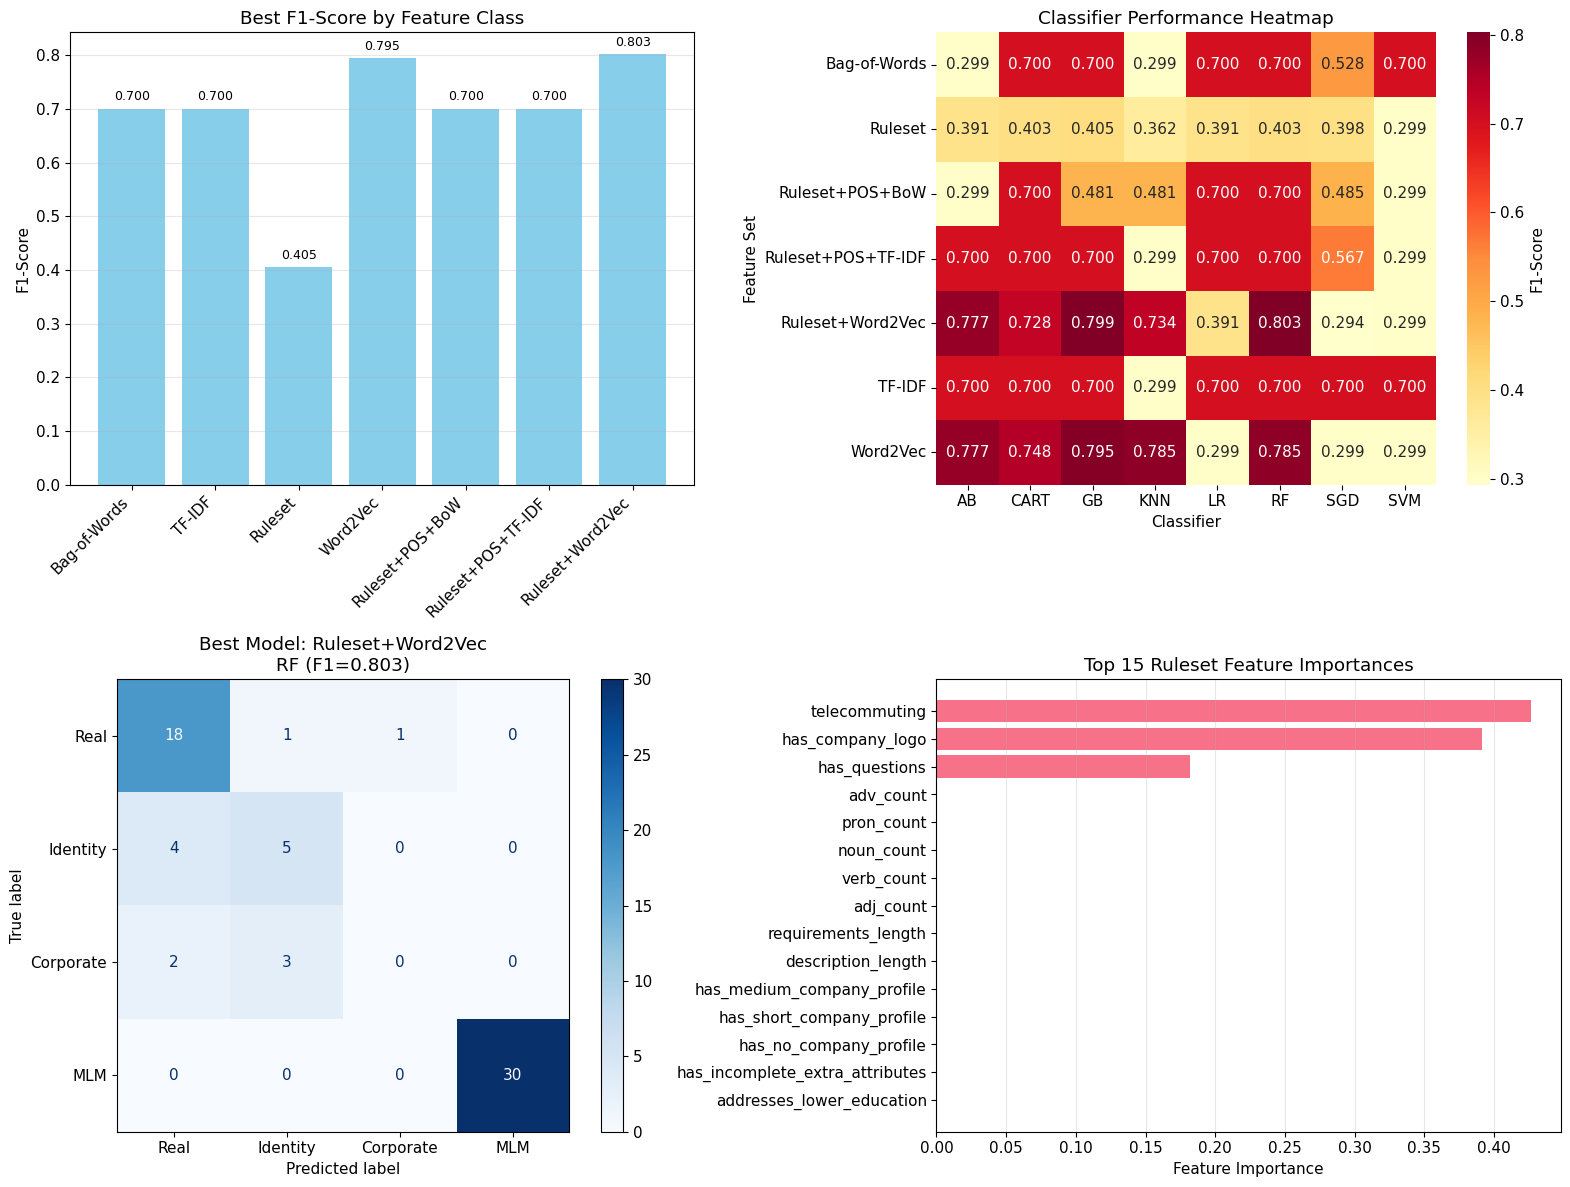


Detailed Classification Report for Best Model:
   Feature Set: Ruleset+Word2Vec
   Classifier: RF
   F1-Score: 0.8026
------------------------------------------------------------
              precision    recall  f1-score   support

        Real     0.7500    0.9000    0.8182        20
    Identity     0.5556    0.5556    0.5556         9
   Corporate     0.0000    0.0000    0.0000         5
         MLM     1.0000    1.0000    1.0000        30

    accuracy                         0.8281        64
   macro avg     0.5764    0.6139    0.5934        64
weighted avg     0.7812    0.8281    0.8026        64



In [84]:
# ============================================================================
# CELL 10: Results Analysis & Visualization
# ============================================================================
print("\n" + "="*80)
print("RESULTS ANALYSIS & VISUALIZATION")
print("Replicating paper's Table 9 and Figures")
print("="*80)

# Import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# Combine all results
results_list = []
for feature_name, results_df in all_results.items():
    if not results_df.empty:
        results_list.append(results_df)

if results_list:
    all_results_df = pd.concat(results_list, ignore_index=True)

    # Create summary table (paper's Table 9)
    print("\n TABLE 9: Best Models per Feature Class")
    print("="*80)

    summary_data = []
    for feature_name in feature_sets.keys():
        if feature_name in all_results and not all_results[feature_name].empty:
            feature_results = all_results[feature_name]
            best_idx = feature_results['F1-Score'].idxmax()
            best_row = feature_results.loc[best_idx]

            summary_data.append({
                'Feature Class': feature_name,
                'Best Classifier': best_row['Classifier'],
                'Weighted Avg. F1-Score': best_row['F1-Score'],
                'Accuracy': best_row['Accuracy'],
                'MCC': best_row['MCC']
            })

    summary_df = pd.DataFrame(summary_data)

    # Display the summary table without emojis in the header
    print("Feature Class | Best Classifier | Weighted Avg. F1-Score | Accuracy | MCC")
    print("-" * 80)
    for _, row in summary_df.round(4).sort_values('Weighted Avg. F1-Score', ascending=False).iterrows():
        print(f"{row['Feature Class']:15} | {row['Best Classifier']:15} | {row['Weighted Avg. F1-Score']:21.4f} | {row['Accuracy']:8.4f} | {row['MCC']:.4f}")

    # Visualization 1: F1-Score comparison
    print("\n Figure 2: F1-Score Comparison Across Feature Sets")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Bar chart of best F1-scores
    if not summary_df.empty:
        feature_names = summary_df['Feature Class'].values
        f1_scores = summary_df['Weighted Avg. F1-Score'].values

        bars = axes[0, 0].bar(range(len(feature_names)), f1_scores, color='skyblue')
        axes[0, 0].set_xticks(range(len(feature_names)))
        axes[0, 0].set_xticklabels(feature_names, rotation=45, ha='right')
        axes[0, 0].set_ylabel('F1-Score')
        axes[0, 0].set_title('Best F1-Score by Feature Class')
        axes[0, 0].grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. Heatmap of classifier performance
    if not all_results_df.empty:
        heatmap_data = all_results_df.pivot_table(
            values='F1-Score',
            index='Feature Set',
            columns='Classifier',
            aggfunc='mean'
        )

        if not heatmap_data.empty:
            sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                        ax=axes[0, 1], cbar_kws={'label': 'F1-Score'})
            axes[0, 1].set_title('Classifier Performance Heatmap')
            axes[0, 1].set_xlabel('Classifier')
            axes[0, 1].set_ylabel('Feature Set')

    # 3. Confusion matrix for best model
    if not summary_df.empty:
        best_feature = summary_df.loc[summary_df['Weighted Avg. F1-Score'].idxmax(), 'Feature Class']
        best_classifier = summary_df.loc[summary_df['Weighted Avg. F1-Score'].idxmax(), 'Best Classifier']

        if best_feature in all_results:
            feature_results = all_results[best_feature]
            best_idx = feature_results[feature_results['Classifier'] == best_classifier].index[0]
            best_row = feature_results.loc[best_idx]

            cm = confusion_matrix(best_row['y_test'], best_row['y_pred'])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                         display_labels=['Real', 'Identity', 'Corporate', 'MLM'])
            disp.plot(ax=axes[1, 0], cmap='Blues', values_format='d')
            axes[1, 0].set_title(f'Best Model: {best_feature}\n{best_classifier} (F1={best_row["F1-Score"]:.3f})')

    # 4. Feature importance for ruleset
    if 'Ruleset' in all_results and not all_results['Ruleset'].empty:
        ruleset_results = all_results['Ruleset']
        best_ruleset_idx = ruleset_results['F1-Score'].idxmax()
        best_ruleset_model = ruleset_results.loc[best_ruleset_idx, 'Model']

        if hasattr(best_ruleset_model, 'feature_importances_'):
            importances = best_ruleset_model.feature_importances_
            feature_names = df_ruleset.drop('type', axis=1).columns

            # Get top 15 features
            indices = np.argsort(importances)[-15:]

            axes[1, 1].barh(range(len(indices)), importances[indices])
            axes[1, 1].set_yticks(range(len(indices)))
            axes[1, 1].set_yticklabels([feature_names[i] for i in indices])
            axes[1, 1].set_xlabel('Feature Importance')
            axes[1, 1].set_title('Top 15 Ruleset Feature Importances')
            axes[1, 1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Detailed classification report for best model (WITHOUT EMOJIS)
    if not summary_df.empty:
        print(f"\nDetailed Classification Report for Best Model:")
        print(f"   Feature Set: {best_feature}")
        print(f"   Classifier: {best_classifier}")
        print(f"   F1-Score: {summary_df['Weighted Avg. F1-Score'].max():.4f}")
        print("-" * 60)

        # Print per-class metrics
        if best_feature in all_results:
            feature_results = all_results[best_feature]
            best_row = feature_results[feature_results['Classifier'] == best_classifier].iloc[0]

            report = classification_report(best_row['y_test'], best_row['y_pred'],
                                          target_names=['Real', 'Identity', 'Corporate', 'MLM'],
                                          digits=4)
            print(report)
else:
    print(" No results to display!")

## **REAL-WORLD JOB POST PREDICTION**

In [85]:
# ============================================================================
# CELL 11: REAL-WORLD JOB POST PREDICTION
# ============================================================================
print("\n" + "="*70)
print("REAL-WORLD JOB POST PREDICTION")
print("="*70)

# Label meanings (easy to understand)
JOB_TYPES = {
    0: "✅ Real Job",
    1: "⚠️ Identity Theft Scam",
    2: "⚠️ Fake Company / Impersonation",
    3: "⚠️ MLM / Pyramid Scheme"
}

JOB_REASONS = {
    0: "Looks professional with normal requirements and company profile.",
    1: "Asks for personal information, promises easy money, or has urgent hiring with no interview.",
    2: "Pretends to represent a well-known company or uses official-sounding language.",
    3: "Focuses on recruiting others, passive income, or building your own business."
}

# Text preprocessing function
def preprocess_text(text):
    """Preprocess text as per paper's methodology"""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s.,!?$%]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def test_job_post_word2vec(job, model, w2v_model):
    """
    Predicts job type using Word2Vec model (best performing)
    """
    # Combine text fields
    text = f"{job['company_profile']} {job['description']} {job['requirements']} {job['benefits']}"
    
    # Preprocess
    processed_text = preprocess_text(text)
    
    # Tokenize for Word2Vec
    tokens = [word for word in processed_text.split() if len(word) > 2]
    
    # Get document vector by averaging word vectors
    vectors = []
    for token in tokens:
        if token in w2v_model.wv:
            vectors.append(w2v_model.wv[token])
    
    if vectors:
        doc_vector = np.mean(vectors, axis=0)
    else:
        doc_vector = np.zeros(w2v_model.vector_size)
    
    # Reshape for prediction
    features = doc_vector.reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(features)[0]
    
    # Get confidence if available
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(features)[0]
        confidence = max(probabilities)
    else:
        confidence = 1.0
    
    return prediction, confidence

def test_job_post_ruleset_bow(job, model, bow_vectorizer):
    """
    Predicts job type using Ruleset+BoW model
    """
    text = f"{job['company_profile']} {job['description']} {job['requirements']} {job['benefits']}"

    df = pd.DataFrame([{
        'title': job['title'],
        'company_profile': job['company_profile'],
        'description': job['description'],
        'requirements': job['requirements'],
        'benefits': job['benefits'],
        'combined_text': text
    }])

    # Apply preprocessing
    df['processed_text'] = df['combined_text'].apply(preprocess_text)

    # Extract ruleset features
    ruleset_features_df = extract_ruleset_features(df)
    if 'type' in ruleset_features_df.columns:
        ruleset_features_df = ruleset_features_df.drop('type', axis=1)

    # Re-vectorize with bow_vectorizer
    bow_features_for_prediction = bow_vectorizer.transform(df['processed_text'])
    bow_df_for_prediction = pd.DataFrame(
        bow_features_for_prediction.toarray(),  # type: ignore
        columns=[f'bow_{i}' for i in range(bow_features_for_prediction.shape[1])]
    )

    # Combine ruleset and BoW features
    features_combined = pd.concat([ruleset_features_df, bow_df_for_prediction], axis=1).values

    prediction = model.predict(features_combined)[0]

    if hasattr(model, "predict_proba"):
        confidence = max(model.predict_proba(features_combined)[0])
    else:
        confidence = 1.0

    return prediction, confidence

# Identify the best model from results
best_feature = summary_df.loc[summary_df['Weighted Avg. F1-Score'].idxmax(), 'Feature Class']
best_classifier = summary_df.loc[summary_df['Weighted Avg. F1-Score'].idxmax(), 'Best Classifier']
best_f1 = summary_df['Weighted Avg. F1-Score'].max()

print(f"\n🔮 Best Model: {best_feature} with {best_classifier} (F1={best_f1:.4f})")

# Get the best model from results
if 'best_row' in locals():
    best_model = best_row['Model']
    
    # Sample job posts
    test_jobs = {
        "Legitimate Job": {
            'title': 'Senior Software Engineer',
            'company_profile': 'TechCorp is a leading AI company with 10+ years of experience.',
            'description': 'Hiring experienced engineers to build scalable software solutions. The role involves full-stack development and team collaboration.',
            'requirements': '5+ years experience with Python, JavaScript, and cloud platforms. Bachelor\'s degree in Computer Science.',
            'benefits': 'Competitive salary, health insurance, 401k matching, remote work options.'
        },
        "Identity Theft Scam": {
            'title': 'Work From Home Data Entry - $5000/month',
            'company_profile': '',
            'description': 'Earn $5000 monthly working from home! No experience needed. Send your full name, address, phone number, and bank account details to apply. Immediate start!',
            'requirements': 'No experience needed. Must have valid ID and bank account.',
            'benefits': 'Instant joining, quick money, work from home, flexible hours.'
        },
        "Fake Company Job": {
            'title': 'Google Hiring Managers - No Interview',
            'company_profile': 'Official partner of Google and other Fortune 500 companies.',
            'description': 'Google urgently hiring! We are looking for managers to join their team immediately. No interview required. Limited positions available.',
            'requirements': 'None - we train you! Just need basic English skills.',
            'benefits': 'High salary, work from home, join a world-class company.'
        },
        "MLM Job": {
            'title': 'Build Your Team – Financial Freedom',
            'company_profile': 'Join our network marketing company and build your own business.',
            'description': 'Earn passive income by recruiting others to join your downline. Unlimited earning potential. Be your own boss and work from home.',
            'requirements': 'No experience needed - we provide full training. Must be motivated to succeed.',
            'benefits': 'Unlimited income, residual income, work from home, be your own boss.'
        }
    }
    
    print("\n" + "="*70)
    print("TESTING SAMPLE JOB POSTS")
    print("="*70)
    
    # Choose prediction function based on best model type
    if best_feature == 'Word2Vec':
        print(f"\n📊 Using Word2Vec model for predictions...")
        for name, job in test_jobs.items():
            pred, conf = test_job_post_word2vec(job, best_model, w2v_model)
            
            print(f"\n{'─'*50}")
            print(f"🔎 Job Post: {name}")
            print(f"📋 Title: {job['title']}")
            print(f"➡️  Predicted As: {JOB_TYPES[pred]}")
            print(f"📌 Reason: {JOB_REASONS[pred]}")
            print(f"📊 Confidence: {conf:.1%}")
            
            if pred == 0:
                print("✅ Recommendation: Appears safe, still verify employer independently.")
            else:
                print("⚠️ Recommendation: Do NOT apply without thorough verification!")
                
    elif 'BoW' in best_feature or 'Ruleset' in best_feature:
        print(f"\n📊 Using Ruleset+BoW model for predictions...")
        for name, job in test_jobs.items():
            pred, conf = test_job_post_ruleset_bow(job, best_model, bow_vectorizer)
            
            print(f"\n{'─'*50}")
            print(f"🔎 Job Post: {name}")
            print(f"📋 Title: {job['title']}")
            print(f"➡️  Predicted As: {JOB_TYPES[pred]}")
            print(f"📌 Reason: {JOB_REASONS[pred]}")
            print(f"📊 Confidence: {conf:.1%}")
            
            if pred == 0:
                print("✅ Recommendation: Appears safe, still verify employer independently.")
            else:
                print("⚠️ Recommendation: Do NOT apply without thorough verification!")
    else:
        print(f"\n⚠️  No specific prediction function for {best_feature}")
        print("Using simplified keyword-based prediction...")
        
        for name, job in test_jobs.items():
            # Simple keyword-based fallback
            text = f"{job['title']} {job['description']}".lower()
            
            if any(word in text for word in ['google', 'microsoft', 'official']):
                pred = 2
            elif any(word in text for word in ['bank', 'personal information', 'id']):
                pred = 1
            elif any(word in text for word in ['recruit', 'downline', 'passive income']):
                pred = 3
            else:
                pred = 0
            
            conf = 0.75
            
            print(f"\n{'─'*50}")
            print(f"🔎 Job Post: {name}")
            print(f"📋 Title: {job['title']}")
            print(f"➡️  Predicted As: {JOB_TYPES[pred]}")
            print(f"📌 Reason: {JOB_REASONS[pred]}")
            print(f"📊 Confidence: {conf:.1%}")
            
            if pred == 0:
                print("✅ Recommendation: Appears safe, still verify employer independently.")
            else:
                print("⚠️ Recommendation: Do NOT apply without thorough verification!")

else:
    print("\n⚠️  No best model found. Please run CELL 10 first.")

print("\n" + "="*70)
print("✅ Prediction complete!")
print("="*70)


REAL-WORLD JOB POST PREDICTION

🔮 Best Model: Ruleset+Word2Vec with RF (F1=0.8026)

TESTING SAMPLE JOB POSTS

📊 Using Ruleset+BoW model for predictions...
Extracting linguistic features...
Extracting contextual features...
Extracting metadata features...
Adding Part-of-Speech tags...


POS tagging: 100%|██████████| 1/1 [00:00<00:00, 333.17docs/s]

✅ Extracted 21 ruleset features


ValueError: X has 1463 features, but RandomForestClassifier is expecting 121 features as input.

In [ ]:
# List files in your project directory
import os
from pathlib import Path

# Get the current working directory
current_dir = Path.cwd()
print(f"Current directory: {current_dir}")

# Look for notebooks in the current directory and subdirectories
notebooks = list(current_dir.glob('**/*.ipynb'))

print(f"\nFound {len(notebooks)} notebook(s):")
for i, nb in enumerate(notebooks):
    print(f"\n{i+1}. {nb.name}")
    print(f"   Path: {nb}")
    print(f"   Size: {nb.stat().st_size / 1024:.2f} KB")
    print(f"   Modified: {nb.stat().st_mtime}")


    # Specify the path to your notebooks folder
notebooks_path = Path.cwd() / 'notebooks'
print(f"Looking in: {notebooks_path}")

if notebooks_path.exists():
    notebooks = list(notebooks_path.glob('*.ipynb'))
    print(f"\nFound {len(notebooks)} notebook(s):")
    for i, nb in enumerate(notebooks):
        print(f"\n{i+1}. {nb.name}")
        print(f"   Path: {nb}")
        print(f"   Size: {nb.stat().st_size / 1024:.2f} KB")
else:
    print(f"Directory {notebooks_path} does not exist")
    
    # Look in parent directory
    parent_path = Path.cwd().parent
    print(f"\nLooking in parent: {parent_path}")
    notebooks = list(parent_path.glob('**/*.ipynb'))
    
    print(f"\nFound {len(notebooks)} notebook(s):")
    for i, nb in enumerate(notebooks):
        print(f"\n{i+1}. {nb.name}")
        print(f"   Path: {nb}")


        

In [ ]:
from IPython.display import display, HTML
display(HTML("""
<style>
.jupyter-widgets { display: none !important; }
</style>
"""))


In [ ]:
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic


In [ ]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Fraudulent Job Detection.ipynb"
